## Task I
### Question: 
Build and populate necessary tables
#### Core Code with expected output:

In [1]:
import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
import pandas as pd

spark = SparkSession.builder \
    .appName("fifa") \
    .config("spark.driver.extraClassPath", "/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pyspark/jars/postgresql-42.7.4.jar") \
    .getOrCreate()

24/11/08 17:45:57 WARN Utils: Your hostname, Jiayis-MacBook-Pro-7.local resolves to a loopback address: 127.0.0.1; using 172.26.76.78 instead (on interface en0)
24/11/08 17:45:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/08 17:45:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read one of data to get the headers
data_sample = pd.read_csv("/Users/jiayi/Desktop/System-ToolChain-AI/Course Project/course-project-option-i-Kitiyaparnnn/data/players_15.csv", nrows=2)
column_names = list(data_sample.columns)

In [3]:
def infer_sql_type(dtype):
    """Map pandas data type to PostgreSQL"""
    if pd.api.types.is_integer_dtype(dtype):
        return "INT"
    elif pd.api.types.is_float_dtype(dtype):
        return "FLOAT"
    elif pd.api.types.is_bool_dtype(dtype):
        return "BOOLEAN"
    else:
        return "VARCHAR"

# Infer data type for each column in Postgres
column_types = {col: infer_sql_type(dtype) for col, dtype in zip(data_sample.columns, data_sample.dtypes)}

# Create a new column of year
column_types['year'] = "INT"

# Create a new column of gender
column_types['gender'] = "VARCHAR"

# Print the crrent result
for col, col_type in column_types.items():
    print(f"{col}: {col_type}")

sofifa_id: INT
player_url: VARCHAR
short_name: VARCHAR
long_name: VARCHAR
player_positions: VARCHAR
overall: INT
potential: INT
value_eur: FLOAT
wage_eur: FLOAT
age: INT
dob: VARCHAR
height_cm: INT
weight_kg: INT
club_team_id: FLOAT
club_name: VARCHAR
league_name: VARCHAR
league_level: INT
club_position: VARCHAR
club_jersey_number: INT
club_loaned_from: FLOAT
club_joined: VARCHAR
club_contract_valid_until: INT
nationality_id: INT
nationality_name: VARCHAR
nation_team_id: FLOAT
nation_position: VARCHAR
nation_jersey_number: INT
preferred_foot: VARCHAR
weak_foot: INT
skill_moves: INT
international_reputation: INT
work_rate: VARCHAR
body_type: VARCHAR
real_face: VARCHAR
release_clause_eur: FLOAT
player_tags: VARCHAR
player_traits: VARCHAR
pace: INT
shooting: INT
passing: INT
dribbling: INT
defending: INT
physic: INT
attacking_crossing: INT
attacking_finishing: INT
attacking_heading_accuracy: INT
attacking_short_passing: INT
attacking_volleys: INT
skill_dribbling: INT
skill_curve: INT
skil

In [4]:
# Create a new table names "fifa"
table = "dataset" 
columns = ",\n    ".join([f'"{col}" {dtype}' for col, dtype in column_types.items()])

create_table = f"""
CREATE SCHEMA fifa;
CREATE TABLE fifa.{table} (
    id SERIAL PRIMARY KEY,
    {columns}
);
"""

print(create_table)


CREATE SCHEMA fifa;
CREATE TABLE fifa.dataset (
    id SERIAL PRIMARY KEY,
    "sofifa_id" INT,
    "player_url" VARCHAR,
    "short_name" VARCHAR,
    "long_name" VARCHAR,
    "player_positions" VARCHAR,
    "overall" INT,
    "potential" INT,
    "value_eur" FLOAT,
    "wage_eur" FLOAT,
    "age" INT,
    "dob" VARCHAR,
    "height_cm" INT,
    "weight_kg" INT,
    "club_team_id" FLOAT,
    "club_name" VARCHAR,
    "league_name" VARCHAR,
    "league_level" INT,
    "club_position" VARCHAR,
    "club_jersey_number" INT,
    "club_loaned_from" FLOAT,
    "club_joined" VARCHAR,
    "club_contract_valid_until" INT,
    "nationality_id" INT,
    "nationality_name" VARCHAR,
    "nation_team_id" FLOAT,
    "nation_position" VARCHAR,
    "nation_jersey_number" INT,
    "preferred_foot" VARCHAR,
    "weak_foot" INT,
    "skill_moves" INT,
    "international_reputation" INT,
    "work_rate" VARCHAR,
    "body_type" VARCHAR,
    "real_face" VARCHAR,
    "release_clause_eur" FLOAT,
    "player_

In [5]:
# Read male data
total_data = spark.read.csv('/Users/jiayi/Desktop/System-ToolChain-AI/Course Project/archive/players_15.csv',header=True, inferSchema=True).toDF(*column_names)
total_data = total_data.withColumn("year", lit(2015))
total_data = total_data.withColumn("gender", lit("male"))

for i in range(16,23):
    data = spark.read.csv(f'/Users/jiayi/Desktop/System-ToolChain-AI/Course Project/archive/players_{i}.csv',header=True, inferSchema=True)
    data = data.toDF(*column_names)
    data = data.withColumn("year", lit(2000+i))
    data = data.withColumn("gender", lit("male"))
    total_data = total_data.union(data)
print("total male players: ",total_data.count())

# Read female data
for i in range(16,23):
    data = spark.read.csv(f'/Users/jiayi/Desktop/System-ToolChain-AI/Course Project/archive/female_players_{i}.csv',header=True, inferSchema=True)
    data = data.toDF(*column_names)
    data = data.withColumn("year", lit(2000+i))
    data = data.withColumn("gender", lit("female"))
    total_data = total_data.union(data)
    
print("total female players: ",total_data.count())   

# Ensure every record can be uniquely identified in the database table
print("total unique records: ",total_data.distinct().count())

total male players:  142079
total female players:  144323


24/11/08 17:46:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


total unique records:  144323


In [6]:
# Ingest data to PostgresDB
postgres_url = "jdbc:postgresql://localhost:5432/jiayi"
postgres_properties = {
    "user": "jiayi", 
    "password": "Liu123jiayi",
    "driver": "org.postgresql.Driver"
}

# Write data to DB
total_data.write \
    .jdbc(url=postgres_url, table="fifa", mode="overwrite", properties=postgres_properties)

# Read data from DB
data_postgres = spark.read \
    .jdbc(url=postgres_url, table="fifa", properties=postgres_properties)

data_postgres.printSchema()
data_postgres.show(5, vertical=True)

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: string (nullable = true)
 |-- wage_eur: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: string (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: string (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |

In [ ]:
data_postgres.tail(5)

[Row(sofifa_id=262371, player_url='https://sofifa.com/player/262371/craig-dundas/220002', short_name='C. Dundas', long_name='Craig Dundas', player_positions='ST', overall=56, potential=56, value_eur=None, wage_eur='1000.0', age=40, dob=datetime.date(1981, 2, 16), height_cm=188, weight_kg=89, club_team_id='110799.0', club_name='Sutton United', league_name='English League Two', league_level='4', club_position='RES', club_jersey_number='14', club_loaned_from=None, club_joined='2019-07-01', club_contract_valid_until='2022', nationality_id=14, nationality_name='England', nation_team_id=None, nation_position=None, nation_jersey_number=None, preferred_foot='Right', weak_foot=3, skill_moves=2, international_reputation=1, work_rate='Medium/Low', body_type='Normal (185+)', real_face='No', release_clause_eur=None, player_tags=None, player_traits=None, pace=50, shooting=56, passing=39, dribbling=53, defending=23, physic=63, attacking_crossing=34, attacking_finishing=58, attacking_heading_accuracy=

24/11/08 17:46:15 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Task II

### Question 1: 
In Year X, what were the Y clubs that had the highest number of players with
contracts ending in year Z (or after)?
- X is a year between (2015 and 2022, inclusively).
- Y is a positive integer.
- Z is a year that can hold the value of 2023 or a year after it.

#### Core Code with expected output:

***Experiment***

In [ ]:
# Explore "club_contract_valid_until" column to see possible values of Z
data_postgres.select("club_contract_valid_until").distinct().show()

+-------------------------+
|club_contract_valid_until|
+-------------------------+
|                     2016|
|                     2020|
|                     2031|
|                     2026|
|                     2019|
|                     2017|
|                     2014|
|                     2028|
|                     2018|
|                     2022|
|                     2025|
|                     2023|
|                     2021|
|                     2024|
|                     2015|
|                     2027|
|                     NULL|
+-------------------------+



*Result*

Possible values for Z: 2031, 2026, 2028, 2025, 2023, 2024, 2027

***Query Function***

In [ ]:
from pyspark.sql.functions import col
def query_no_clubs(X, Y, Z):
    # Filter the data as needed and group by club_name
    club_counts = data_postgres.filter(f"club_contract_valid_until == {Z}") \
                               .filter(f"year == {X}") \
                               .filter("gender == 'male'") \
                               .groupBy("club_name") \
                               .count() \
                               .sort("count", ascending=False) \
                               .limit(Y)
    return club_counts

***Function Testing***

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

schema = StructType([
    StructField("year", IntegerType(), True),
    StructField("contract_ending", IntegerType(), True),
    StructField("no_of_clubs", IntegerType(), True)
])

# Create an empty DataFrame with the defined schema
resultDF = spark.createDataFrame([], schema=schema)


# data =[]
# X = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
# Z = [2031, 2026, 2028, 2025, 2023, 2024, 2027]

# Specify y: #clubs that had the highest number of players 
# For example
no_of_clubs = query_no_clubs(2022,5,2023)
print(f"In year {2022} and club contract valid until {2023}:")
no_of_clubs.show()

In year 2022 and club contract valid until 2023:
+--------------------+-----+
|           club_name|count|
+--------------------+-----+
|En Avant de Guingamp|   19|
| Club Atlético Lanús|   17|
|       Lechia Gdańsk|   17|
|            Barnsley|   16|
|        Kasimpaşa SK|   16|
+--------------------+-----+



### Question 2: 
In sports, maturity and energy of teams depend on the average age of team players (among other factors). Therefore, it’s important to have a function that can find clubs with such features.
- List the X clubs with the highest (or lowest) average player age for a given year Y.
    - X represents a positive integer, but you should handle a scenario if X is not positive value.
    - Y represents a year between 2015 and 2022 inclusively.
    - Provide the user with the ability to choose if they want the highest average age or the lowest average age.
    - Make sure to handle this scenario as well: if the user requests 5 clubs with highest averages but there are 3 clubs that share the same count at rank number 5, please include all of them in your output

#### Core Code with expected output:

***Query Function***

In [ ]:
def top_avg_age_clubs(X, Y, filter):
    avg_by_group = data_postgres.filter(f"year == {Y}") \
                            .filter("gender == 'male'") \
                            .groupBy("club_name") \
                            .agg(avg("age").alias("average_age"))
    
    # Find the distinct avg age
    avg_by_group.select("average_age").distinct().orderBy("average_age")
    
    # Filter from the highest avg age
    if filter == "highest":
        top = avg_by_group.select("average_age").distinct().sort("average_age", ascending=False).limit(X).collect()
        top_boundary = top[X-1][0]
        return avg_by_group.filter(f"average_age >= {top_boundary}").sort("average_age", ascending=False).show()
    
    # Filter from the lowest avg age
    else:
        bottom = avg_by_group.select("average_age").distinct().sort("average_age", ascending=True).limit(X).collect()
        bottom_boundary = bottom[X-1][0]
        return avg_by_group.filter(f"average_age <= {bottom_boundary}").sort("average_age", ascending=True).show()

***Function Testing***

In [ ]:
top_avg_age_clubs(5, 2015, "highest")

+--------------------+------------------+
|           club_name|       average_age|
+--------------------+------------------+
|           Cruz Azul|28.071428571428573|
|        Arsenal Tula|             28.04|
|Podbeskidzie Biel...|27.962962962962962|
|       Fenerbahçe SK|             27.88|
|Leones Negros de ...| 27.79310344827586|
+--------------------+------------------+



### Question 3: 
What is the most popular nationality in the dataset for each year? (i.e. display the
most frequent nation for 2015, 2016, etc.).

#### Core Code with expected output:

***Query Function***

In [ ]:
def display_popular_nation():
    # Find the minimum and maximum year in the db
    max_year = data_postgres.agg(max("year")).collect()[0][0]
    min_year = data_postgres.agg(min("year")).collect()[0][0]

    # Group nations for each years
    for i in range(min_year,max_year + 1):
        no_nations = data_postgres.filter(f"year == {i}") \
                            .filter("gender == 'male'") \
                            .groupBy("nationality_name") \
                            .count()
        
        max_count = no_nations.agg(max("count")).collect()[0][0]
        print(f"The most popularity nationality & its total players in year {i}:")
        no_of_nations = no_nations.filter(col("count") == max_count).show()
    return no_nations

#### Function Testing:

In [ ]:
no_nations = display_popular_nation()
for row in no_nations.collect():
    print(row)

The most popularity nationality & its total players in year 2015:
+----------------+-----+
|nationality_name|count|
+----------------+-----+
|         England| 1627|
+----------------+-----+

The most popularity nationality & its total players in year 2016:
+----------------+-----+
|nationality_name|count|
+----------------+-----+
|         England| 1519|
+----------------+-----+

The most popularity nationality & its total players in year 2017:
+----------------+-----+
|nationality_name|count|
+----------------+-----+
|         England| 1627|
+----------------+-----+

The most popularity nationality & its total players in year 2018:
+----------------+-----+
|nationality_name|count|
+----------------+-----+
|         England| 1633|
+----------------+-----+

The most popularity nationality & its total players in year 2019:
+----------------+-----+
|nationality_name|count|
+----------------+-----+
|         England| 1625|
+----------------+-----+

The most popularity nationality & its to

## Task III

### Data Collection

#### Data Ingestion from the source

In [8]:
# Ingest male player data
male_data = data_postgres.filter("gender == 'male'")
male_data.show()

+---------+--------------------+-----------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+-------------------+--------------------+------------+-------------+------------------+----------------+-----------+-------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+--------------------+--------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-

#### Data Cleaning & Data Preprocessing

***Note:*** prediction target is `value_eur`

**Delete Some irrvelent columns**

In [9]:
from pyspark.sql.functions import col, substring, split
from pyspark.sql.types import IntegerType, FloatType, DoubleType

In [10]:
columns_to_drop = [
    'sofifa_id', 'player_url', 'short_name', 'long_name', 'club_position','club_name', 'dob', 
    'club_team_id', 'league_name', 'club_jersey_number', 'club_loaned_from',
    'nation_team_id', 'nation_jersey_number', 'nationality_id', 'nationality_name', 'nation_position',
    'nation_jersey_name', 'body_type', 'real_face', 'release_clause_eur',
    'player_tags', 'player_traits', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 
    'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 
    'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 
    'cub_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url', 'club_logo_url','year','gender', 'player_positions'
]

male_data_filtered = male_data.drop(*columns_to_drop)

# Remaining columns
print("The number of remaining columns: ", len(male_data_filtered.columns))
male_data_filtered.show(1, vertical=True)

The number of remaining columns:  56
-RECORD 0---------------------------------
 overall                     | 94         
 potential                   | 94         
 value_eur                   | 8.7E7      
 wage_eur                    | 575000.0   
 age                         | 31         
 height_cm                   | 185        
 weight_kg                   | 80         
 league_level                | 1          
 club_joined                 | 2009-07-01 
 club_contract_valid_until   | 2018       
 preferred_foot              | Right      
 weak_foot                   | 4          
 skill_moves                 | 5          
 international_reputation    | 5          
 work_rate                   | High/Low   
 pace                        | 92         
 shooting                    | 92         
 passing                     | 81         
 dribbling                   | 91         
 defending                   | 33         
 physic                      | 80         
 attacking_crossi

**Columns Adjustment**

- contract duration data: `club_contract_valid_until` - `club_joined` = `contract_duration`
- split data into 2 columns: `work_rate` into `attacking` and `defensive` 

In [11]:
# Extract the first 4 digits (year) from 'club_joined' and 'club_contract_valid_until'
df = male_data_filtered \
    .withColumn("joined_year", substring(col("club_joined"), 1, 4).cast("int")) \
    .withColumn("contract_until_year", substring(col("club_contract_valid_until"), 1, 4).cast("int"))

# Calculate the difference in years and create a new column 'contract_duration'
df = df.withColumn("contract_duration", col("contract_until_year") - col("joined_year"))

# Display the results
df = df.drop('club_joined', 'club_contract_valid_until', 'joined_year','contract_until_year')


In [12]:
# Split the 'work_rate' column into 'attacking' and 'defensive' columns
df = df.withColumn("attacking", split(col("work_rate"), "/").getItem(0)) \
       .withColumn("defensive", split(col("work_rate"), "/").getItem(1))

df = df.drop("work_rate")

In [13]:
# Check the updated data
print("The number of remaining columns: ", len(df.columns))
df.show(1, vertical=True)

The number of remaining columns:  56
-RECORD 0-------------------------------
 overall                     | 94       
 potential                   | 94       
 value_eur                   | 8.7E7    
 wage_eur                    | 575000.0 
 age                         | 31       
 height_cm                   | 185      
 weight_kg                   | 80       
 league_level                | 1        
 preferred_foot              | Right    
 weak_foot                   | 4        
 skill_moves                 | 5        
 international_reputation    | 5        
 pace                        | 92       
 shooting                    | 92       
 passing                     | 81       
 dribbling                   | 91       
 defending                   | 33       
 physic                      | 80       
 attacking_crossing          | 84       
 attacking_finishing         | 93       
 attacking_heading_accuracy  | 87       
 attacking_short_passing     | 82       
 attacking_volleys  

**Data Missing**

In [14]:
# Final columns to be features
nominal_columns = [
    'preferred_foot', 'attacking', 'defensive'
]

numerical_columns = [
    'international_reputation','overall', 'potential', 'wage_eur', 'age', 'height_cm', 'weight_kg',
    'league_level', 'weak_foot', 'skill_moves',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing',
    'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
    'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
    'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
    'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power',
    'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
    'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
    'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle',
    'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling',
    'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed','contract_duration'
]

target_column = ['value_eur']

In [15]:
# Function to check missing values
def CheckNullValues():
    # List of columns with NULL values
    columns_with_nulls = []

    # Check nominal columns for NULL values
    for column in nominal_columns:
        if df.filter(col(column).isNull()).count() > 0:
            columns_with_nulls.append(column)

    # Check numerical columns for NULL values
    for column in numerical_columns:
        if df.filter(col(column).isNull()).count() > 0:
            columns_with_nulls.append(column)

    # Display the columns with NULL values
    print(f"{len(columns_with_nulls)} columns with NULL values:", columns_with_nulls)

In [16]:
# Null values BEFORE handling
print("BEFORE handling data missing ---")
CheckNullValues()

BEFORE handling data missing ---
11 columns with NULL values: ['wage_eur', 'league_level', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'mentality_composure', 'goalkeeping_speed', 'contract_duration']


- drop the row that has **Null value** in `value_eur`

In [17]:
df = df.dropna(subset=["value_eur"])

- fill the **Null value** with medium value for `wage_eur, league_level, pace, shooting, passing, dribbling, defending, physic, mentality_composure`

In [18]:
# Check for missing or non-numeric columns and attempt to cast them
columns_to_check = ['wage_eur', 'league_level', 'mentality_composure']
for column in columns_to_check:
    if column in df.columns:
        # Attempt to cast to FloatType
        df = df.withColumn(column, col(column).cast(FloatType()))
        # Check if casting was successful
        if df.schema[column].dataType not in (IntegerType(), FloatType(), DoubleType()):
            print(f"Warning: Could not cast {column} to numeric type.")
    else:
        print(f"Warning: {column} does not exist in the DataFrame.")

# Recalculate the median values after casting
median_values = {}
for column in ['wage_eur', 'league_level', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'mentality_composure']:
    if column in df.columns and df.schema[column].dataType in (IntegerType(), FloatType(), DoubleType()):
        median_value = df.filter(col(column).isNotNull()).approxQuantile(column, [0.5], 0.0)[0]
        median_values[column] = median_value
    else:
        print(f"Warning: {column} either does not exist or is not a numeric column.")
print(median_values)

# Fill NULLs with median values
df = df.fillna(median_values)

{'wage_eur': 4000.0, 'league_level': 1.0, 'pace': 69.0, 'shooting': 54.0, 'passing': 58.0, 'dribbling': 63.0, 'defending': 55.0, 'physic': 66.0, 'mentality_composure': 59.0}


- fill the **Null value** with 0 (zero) for `goalkeeping_speed` and `contract_duration`

In [19]:
# Fill NULL values with 0 
df = df.fillna({'goalkeeping_speed': 0, 'contract_duration': 0})

In [20]:
# Null values AFTER handling
print("AFTER handling data missing ---")
CheckNullValues()

AFTER handling data missing ---
0 columns with NULL values: []


In [21]:
# Check the updated data
print("The number of remaining columns: ", len(df.columns))
df.show(1, vertical=True)

The number of remaining columns:  56
-RECORD 0-------------------------------
 overall                     | 94       
 potential                   | 94       
 value_eur                   | 8.7E7    
 wage_eur                    | 575000.0 
 age                         | 31       
 height_cm                   | 185      
 weight_kg                   | 80       
 league_level                | 1.0      
 preferred_foot              | Right    
 weak_foot                   | 4        
 skill_moves                 | 5        
 international_reputation    | 5        
 pace                        | 92       
 shooting                    | 92       
 passing                     | 81       
 dribbling                   | 91       
 defending                   | 33       
 physic                      | 80       
 attacking_crossing          | 84       
 attacking_finishing         | 93       
 attacking_heading_accuracy  | 87       
 attacking_short_passing     | 82       
 attacking_volleys  

**Convert dataset to vectors**

Create a pipline to analyze columns(features) including outliner, boxplot to see feature statistics and normalize dataset to contribute feature vectors 

In [22]:
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from functools import reduce

In [23]:
class OutcomeCreater(Transformer):  # this defines a transformer that creates the outcome column
    def __init__(self):
        super().__init__()

    def _transform(self, dataset: DataFrame) -> DataFrame:
        # using column 'value_eur' as 'outcome'
        output_df = dataset.withColumn('outcome', col('value_eur').cast(DoubleType()))

                                       
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in numerical_columns:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))
        return output_df

class DelectOutliers(Transformer):
    def __init__(self):
        super().__init__()

    def column_add(self, a, b):
        return a.__add__(b)
    
    def _transform(self, dataset: DataFrame) -> DataFrame:
        # Identifying the numerical columns in a spark dataframe
        numeric_columns = [column[0] for column in dataset.dtypes if column[1] in ['int', 'double']]

        # Using the `for` loop to create new columns by identifying the outliers for each feature
        for column in numeric_columns:
            # Calculate the quartiles and IQR for the current numerical column
            Q1 = dataset.approxQuantile(column, [0.25], relativeError=0)[0]
            Q3 = dataset.approxQuantile(column, [0.75], relativeError=0)[0]
            IQR = Q3 - Q1

            # Calculate the outlier bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Create an outlier indicator column for the current column
            isOutlierCol = f'is_outlier_{column}'
            dataset = dataset.withColumn(isOutlierCol, when((col(column) > upper_bound) | (col(column) < lower_bound), 1).otherwise(0))

        # Selecting the specific columns that indicate outliers
        selected_columns = [column for column in dataset.columns if column.startswith("is_outlier")]

        # Adding all the outlier columns into a new column "total_outliers" to see the total number of outliers
        if selected_columns:
            dataset = dataset.withColumn('total_outliers', reduce(self.column_add, [dataset[col] for col in selected_columns]))

            # Dropping the extra columns created above, just to create a clean dataframe without extra columns
            dataset = dataset.drop(*selected_columns)
        
        # Filtering out rows where 'total_outliers' > 0 (indicating that row is an outlier)
        dataset = dataset.filter(col('total_outliers') == 0).drop('total_outliers')

        return dataset

class StatAnalysis(Transformer):
    def __init__(self, numerical_columns=None):
        self.numerical_cols = numerical_columns
        self.analyzed = False

    def _transform(self, dataset: DataFrame) -> DataFrame:
        if not self.analyzed:
            self.analyze(dataset)
            self.analyzed = True 
        return dataset

    def analyze(self, dataset: DataFrame) -> None:
        print("The statistics for numerical_cols:")
        numerical_data = dataset.select(self.numerical_cols)
        numerical_data.summary().show(truncate=False, vertical=True)

        print("The Boxplot for numerical_cols:")
        converted_data = numerical_data.toPandas()
        plt.boxplot(converted_data)
        
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()
    
    # Stage where finding outliers and delete
    stage_delete_outliers = DelectOutliers()

    # Stage where calculate statistics for numerical_cols and plot boxplot
    stage_boxplot = StatAnalysis(numerical_columns=numerical_columns)

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_columns]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_columns]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_columns, outputCols = nominal_id_cols)

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = numerical_columns+nominal_onehot_cols
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')

    # Stage for creating the outcome column
    stage_outcome = OutcomeCreater()
    value_eur_assembler = VectorAssembler(inputCols=['outcome'], outputCol='outcome_vector')
    stage_scaler2 = StandardScaler(inputCol='outcome_vector', outputCol='outcome_scaled')

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_columns+nominal_id_cols+
        nominal_onehot_cols+ numerical_columns + ['vectorized_features'])
    
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[
        stage_typecaster, 
        stage_delete_outliers,
        stage_boxplot,
        stage_nominal_indexer,
        stage_nominal_onehot_encoder,
        stage_vector_assembler,
        stage_scaler,
        stage_outcome,
        value_eur_assembler,
        stage_scaler2,
        stage_column_dropper])
    
    return pipeline 

The statistics for numerical_cols:


-RECORD 0-----------------------------------------
 summary                     | count              
 international_reputation    | 55964              
 overall                     | 55964              
 potential                   | 55964              
 wage_eur                    | 55964              
 age                         | 55964              
 height_cm                   | 55964              
 weight_kg                   | 55964              
 league_level                | 55964              
 weak_foot                   | 55964              
 skill_moves                 | 55964              
 pace                        | 55964              
 shooting                    | 55964              
 passing                     | 55964              
 dribbling                   | 55964              
 defending                   | 55964              
 physic                      | 55964              
 attacking_crossing          | 55964              
 attacking_finishing         | 

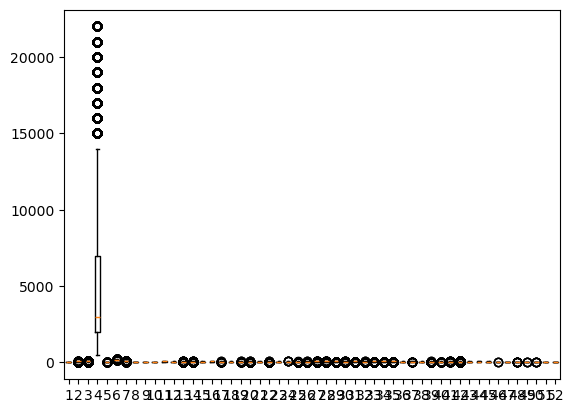

In [24]:
# Get the Pipeline, and need to fit pipline to data
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(df)

# Print the DataFrame after data scaling step within the pipeline by pandas table
data_df = preprocess_pipeline_model.transform(df)

In [25]:
# Display plpline's result including "feature vectors" and "outcome"
data_df.select("features", "outcome_scaled").distinct().toPandas()

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
def vector_to_value(vector):
    return float(vector[0])

vector_to_value_udf = udf(vector_to_value, DoubleType())
data_df = data_df.withColumn("outcome", vector_to_value_udf("outcome_scaled"))
data_df.select("features", "outcome").show()

+--------------------+-------------------+
|            features|            outcome|
+--------------------+-------------------+
|[0.0,12.799280636...| 0.5090912690316801|
|[0.0,12.799280636...| 0.7225811560449653|
|[0.0,12.799280636...| 0.6240473620388337|
|[0.0,12.799280636...| 0.6568919600408776|
|[0.0,12.799280636...| 0.6568919600408776|
|[0.0,12.799280636...| 0.2134898870132852|
|[0.0,10.944312428...|0.15108515080940185|
|[0.0,10.944312428...|0.06568919600408776|
|[0.0,12.799280636...| 0.4269797740265704|
|[0.0,10.944312428...|0.15108515080940185|
|[0.0,10.944312428...| 0.1576540704098106|
|[0.0,10.944312428...| 0.0788270352049053|
|[0.0,10.944312428...|0.14451623120899307|
|[0.0,10.944312428...|0.15108515080940185|
|[0.0,12.799280636...| 0.2134898870132852|
|[0.0,12.799280636...| 0.2134898870132852|
|[0.0,12.799280636...| 0.4598243720286143|
|[0.0,12.799280636...| 0.6568919600408776|
|[0.0,12.428286994...| 0.6568919600408776|
|[0.0,12.799280636...| 0.9196487440572286|
+----------

### Modeling 

For each classifier/regressor, identify a few tunable parameters for your model and tune the parameters (using proper metric(s)). Then, run the best model (after tuning) on the test data set and record the test accuracy

In [26]:
# Split data into train and test sets
train_df, test_df = data_df.randomSplit([0.7, 0.3], seed=42)

print(f"Training dataset count: {train_df.count()}")
print(f"Testing dataset count: {test_df.count()}")

num_features = len(train_df.select("features").first()["features"])
print(f"Total number of features: {num_features}")

Training dataset count: 39168


Testing dataset count: 16796


Total number of features: 57


#### SparkML

**Linear Regression**

In [27]:
train_df.cache()
train_df

DataFrame[value_eur: string, features: vector, outcome: double, outcome_vector: vector, outcome_scaled: vector]

In [112]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define LinearRegression algorithm
lr = LinearRegression(featuresCol="features", labelCol="outcome")

# Create ParamGrid for Cross Validation
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 100.0])
             .addGrid(lr.maxIter, [5, 10, 15])
             .build())

# Evaluatation
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="mse")

# Create cross-validation tuning
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                    evaluator=evaluator, numFolds=5)

# Fit the cross-validation with train dataset
lr_cv_model = lr_cv.fit(train_df)

# Make predictions
predictions = lr_cv_model.transform(test_df)
MSE = evaluator.evaluate(predictions)
print("Linear Regression Model: Mean Squared Error for Test dataset= " + str(MSE))

24/11/08 17:36:09 WARN Instrumentation: [078f3e32] regParam is zero, which might cause numerical instability and overfitting.
24/11/08 17:36:09 WARN Instrumentation: [078f3e32] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/11/08 17:36:09 WARN Instrumentation: [d5587761] regParam is zero, which might cause numerical instability and overfitting.
24/11/08 17:36:09 WARN Instrumentation: [d5587761] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/11/08 17:36:09 WARN Instrumentation: [776c2532] regParam is zero, which might cause numerical instability and overfitting.
24/11/08 17:36:09 WARN Instrumentation: [776c2532] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/11/08 17:36:10 WARN Instrumentation: [b628300c] regParam is zero, which might cause numerical instability and overfitting.
24/11/08 17:36:10 WARN Instrumentation: [b628300c] Cholesky solv

Linear Regression Model: Mean Squared Error for Test dataset= 0.42694039616574425


**Random Forest Regression**

In [113]:
from pyspark.ml.regression import RandomForestRegressor

# Define Random Forest Regression algorithm
rf = RandomForestRegressor(featuresCol="features", labelCol="outcome")

# Create ParamGrid for Cross Validation
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 7, 9],)
             .addGrid(rf.numTrees, [2, 5, 10])       
             .build())

# Evaluatation
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="mse")

# Create cross-validation tuning
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, 
                    evaluator=evaluator, numFolds=5)

# Fit the cross-validation with train dataset
rf_cv_model = rf_cv.fit(train_df)

# Make predictions
predictions = rf_cv_model.transform(test_df)
MSE = evaluator.evaluate(predictions)
print("Random Forest Model: Mean Squared Error for Test dataset= " + str(MSE))

24/11/08 17:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1217.7 KiB
24/11/08 17:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1200.9 KiB
24/11/08 17:36:37 WARN DAGScheduler: Broadcasting large task binary with size 1216.1 KiB
24/11/08 17:36:44 WARN DAGScheduler: Broadcasting large task binary with size 1189.6 KiB
24/11/08 17:36:50 WARN DAGScheduler: Broadcasting large task binary with size 1222.0 KiB
24/11/08 17:36:52 WARN DAGScheduler: Broadcasting large task binary with size 1191.8 KiB


Random Forest Model: Mean Squared Error for Test dataset= 0.07929131763391412


### Pytorch ML models

**convert spark dataset into pandas for using pytorch**

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

train = train_df.select("features", "outcome").distinct().toPandas()
test = test_df.select("features", "outcome").distinct().toPandas()

# expand the features column into separate 57 columns
features_expanded = pd.DataFrame(train['features'].tolist(), index=train.index)
train = pd.concat([features_expanded, train['outcome']], axis=1)
features_expanded_test = pd.DataFrame(test['features'].tolist(), index=test.index)
test = pd.concat([features_expanded_test, test['outcome']], axis=1)

# Define X_train, y_train, X_test, y_test
X_train = train.drop(columns=['outcome'])
y_train = train['outcome']
X_test = test.drop(columns=['outcome'])
y_test = test['outcome']

print(X_train.shape) 
print(y_train.shape)

# scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# X_train_scaled = scaler_x.fit_transform(X_train)
# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# X_test_scaled = scaler_x.transform(X_test)
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

(39168, 57)
(39168,)


**Linear Regression model in Pytorch**

In [115]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

In [123]:
input_dim = X_train.shape[1]
output_dim = 1
model = LinearRegressionModel(input_dim, output_dim)

#### LR Experiment1 ####
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1)
num_epochs = 1000

for epoch in range(num_epochs):
    model.train() 
    
    outputs = model(torch.tensor(X_train.values, dtype=torch.float32))
    loss = criterion(outputs.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 2.7950
Epoch [200/1000], Loss: 0.5600
Epoch [300/1000], Loss: 0.5342
Epoch [400/1000], Loss: 0.5192
Epoch [500/1000], Loss: 0.5095
Epoch [600/1000], Loss: 0.5027
Epoch [700/1000], Loss: 0.4976
Epoch [800/1000], Loss: 0.4938
Epoch [900/1000], Loss: 0.4907
Epoch [1000/1000], Loss: 0.4882


In [127]:
#### LR Experiment2 ####
LR_model2 = LinearRegressionModel(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(LR_model2.parameters(), lr=0.5)
num_epochs = 2000

for epoch in range(num_epochs):
    LR_model2.train() 
    
    outputs = LR_model2(torch.tensor(X_train.values, dtype=torch.float32))
    loss = criterion(outputs.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [200/2000], Loss: 0.6643
Epoch [400/2000], Loss: 0.5542
Epoch [600/2000], Loss: 0.5176
Epoch [800/2000], Loss: 0.5022
Epoch [1000/2000], Loss: 0.4939
Epoch [1200/2000], Loss: 0.4885
Epoch [1400/2000], Loss: 0.4845
Epoch [1600/2000], Loss: 0.4814
Epoch [1800/2000], Loss: 0.4790
Epoch [2000/2000], Loss: 433.9990


In [128]:
## use LR experiment1 as the best model
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test.values, dtype=torch.float32))
    loss = criterion(y_pred.squeeze(), torch.tensor(y_test.values, dtype=torch.float32))
    print(f"The test loss is: {loss.item():.4f}")

The test loss is: 0.4510


### MLP models with different tuning hypermeters in Pytorch

In [35]:
import torch
import torch.nn as nn

class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        return self.output(x)

input_dim = X_train.shape[1]
model = MLPRegressor(input_dim)

##### MLP Experiment1 ####
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    outputs = model(torch.tensor(X_train.values, dtype=torch.float32))
    loss = criterion(outputs.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.9354
Epoch [200/1000], Loss: 0.9218
Epoch [300/1000], Loss: 0.8994
Epoch [400/1000], Loss: 0.8621
Epoch [500/1000], Loss: 0.8008
Epoch [600/1000], Loss: 0.7197
Epoch [700/1000], Loss: 0.7029
Epoch [800/1000], Loss: 0.6239
Epoch [900/1000], Loss: 0.5880
Epoch [1000/1000], Loss: 0.5551


In [38]:
##### MLP Experiment2 ####
MLP_model2 = MLPRegressor(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(MLP_model2.parameters(), lr=0.01)

num_epochs = 2000
for epoch in range(num_epochs):
    MLP_model2.train()
    outputs = MLP_model2(torch.tensor(X_train.values, dtype=torch.float32))
    loss = criterion(outputs.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/2000], Loss: 0.6010
Epoch [200/2000], Loss: 0.5854
Epoch [300/2000], Loss: 0.3444
Epoch [400/2000], Loss: 0.3865
Epoch [500/2000], Loss: 0.2787
Epoch [600/2000], Loss: 0.2930
Epoch [700/2000], Loss: 0.2190
Epoch [800/2000], Loss: 0.2283
Epoch [900/2000], Loss: 0.2126
Epoch [1000/2000], Loss: 0.1834
Epoch [1100/2000], Loss: 0.1760
Epoch [1200/2000], Loss: 0.1890
Epoch [1300/2000], Loss: 0.1670
Epoch [1400/2000], Loss: 0.1651
Epoch [1500/2000], Loss: 0.1683
Epoch [1600/2000], Loss: 0.1658
Epoch [1700/2000], Loss: 0.1655
Epoch [1800/2000], Loss: 0.1622
Epoch [1900/2000], Loss: 0.1572
Epoch [2000/2000], Loss: 0.1558


In [39]:
## use MLP experiment2 as the best model
MLP_model2.eval()
with torch.no_grad():
    test_outputs = MLP_model2(torch.tensor(X_test.values, dtype=torch.float32))
    test_loss = criterion(test_outputs.squeeze(), torch.tensor(y_test.values, dtype=torch.float32))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.1579


## Task IV